# L3a: Linear models for prediction and classification tasks
This lecture introduces supervised learning and focuses on two important tasks: prediction and classification using linear regression models. The supervised learning problem requires a dataset and a learning algorithm (figured reproduced from the [Applied Machine Learning (Cornell CS5785, Fall 2024) course](https://github.com/kuleshov/cornell-cs5785-2024-applied-ml):
$$ \underbrace{\text{Dataset}}_\text{Features, Attributes, Targets} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

The output is a predictive model that maps inputs to targets. Today, we'll look at linear models. Linear models are easy to implement and interpret, serving as a foundation for more complex predictive analytics algorithms that we'll explore in future lectures. There are several key ideas in this lecture:
* __Supervised learning__ is a type of machine learning where the model is trained on _labeled data_, meaning that each training example includes both the input features (measurements) and the corresponding target (output) variable. The goal is to learn a mapping from inputs to outputs so that the model can make accurate predictions on new, unseen data.
* __Linear regression__ is a statistical method for modeling the relationship between a target variable (output) and one or more features (input) by fitting a linear model to observed data. It provides a simple way to predict outcomes and understand relationships between variables. _The model is linear in the parameters, not necessarily in the features).
* __Continuous variable prediction tasks__: In machine learning, linear regression models are commonly employed for continuous variable prediction tasks. These models enable the estimation of numerical outcomes based on the (non)linear relationships identified between input features and the target variable.
* __Binary classification tasks__: While linear regression is primarily designed to predict continuous outcomes, it can also be adapted for classification tasks by combining the linear regression model with an output function that transforms the continuous target variable predictions into discrete classes or probability estimates. In this lecture, we'll consider binary classification using [the perceptron classification algorithm, developed at Cornell in the 1950s](https://en.wikipedia.org/wiki/Perceptron).

Lecture notes can be found: [here!](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/docs/Notes.pdf)

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl");

### Data
In this lecture, we are going to look at two datasets: the [boston housing dataset](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset) for a continuous variable prediction task and [banknote authentication dataset](https://archive.ics.uci.edu/dataset/267/banknote+authentication) for classification tasks. We'll load both datasets and split them into `training` and `test` data subsets (randomly).
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

#### Boston housing dataset
The Boston Housing Dataset, [available from Kaggle](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset), is derived from information collected by the U.S. Census Service concerning housing in the area of Boston, MA. 
* __Features__: The dataset consists of `13` continuous features (inputs), such as the average number of rooms, the age of the neighborhood, or the distance to potential employers, etc., and a single target (output) variable, the Median value (`mdev`) of owner-occupied homes in units of `1000 USD`. The housing dataset has `490` examples (rows) and a total of `14` features (including the target).

In [6]:
df_bostonhousingdata = CSV.read(joinpath(_PATH_TO_DATA, "data-boston-housing.csv"), DataFrame)

Row,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5


In [7]:
D_housing = Matrix(df_bostonhousingdata); # get the data as a Matrix (alias for Array{Float64,2})
number_of_training_examples_housing = 390; # how many training points for the housing dataset?

Next, let's split the housing dataset into training and testing datasets. We'll store the training data in the `house_training::Array{Float64,2}` array, and the testing in the `house_test::Array{Float64,2}` array.

In [9]:
house_training, house_test = let

    number_of_features = size(D_housing,2); # number of cols of housing data
    number_of_examples = size(D_housing,1); # number of rows of housing data
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples_housing)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    house_training = D_housing[training_index_set |> collect,:];
    house_test = D_housing[test_index_set |> collect,:];

    # return
    house_training,house_test
end;

In [10]:
house_training # number_of_training_examples_housing x 14 (13 features + 1 target)

390×14 Matrix{Float64}:
  0.01311  90.0   1.22  0.0  0.403  …  226.0  17.9  395.93   4.81  35.4
  1.61282   0.0   8.14  0.0  0.538     307.0  21.0  248.31  20.34  13.5
 12.8023    0.0  18.1   0.0  0.74      666.0  20.2  240.52  23.79  10.8
  0.10328  25.0   5.13  0.0  0.453     284.0  19.7  396.9    9.22  19.6
  0.41238   0.0   6.2   0.0  0.504     307.0  17.4  372.08   6.36  31.6
  0.40202   0.0   9.9   0.0  0.544  …  304.0  18.4  395.21  10.36  23.1
  0.09164   0.0  10.81  0.0  0.413     305.0  19.2  390.91   5.52  22.8
  0.65665  20.0   3.97  0.0  0.647     264.0  13.0  391.93   6.9   30.1
  0.14231   0.0  10.01  0.0  0.547     432.0  17.8  388.74  10.45  18.5
  0.10084   0.0  10.01  0.0  0.547     432.0  17.8  395.59  10.16  22.8
  0.0837   45.0   3.44  0.0  0.437  …  398.0  15.2  396.9    5.39  34.9
  5.20177   0.0  18.1   1.0  0.77      666.0  20.2  395.43  11.48  22.7
 11.8123    0.0  18.1   0.0  0.718     666.0  20.2   48.45  22.74   8.4
  ⋮                                 ⋱   

In [11]:
Σ = cov(house_training[:,1:end-1]) # cov of the features excluding the target

13×13 Matrix{Float64}:
   81.7722      -40.5624      24.4734     …   -299.575       29.3599
  -40.5624      540.117      -82.0109          368.964      -71.1481
   24.4734      -82.0109      44.9842         -228.194       30.1638
   -0.129717     -0.300099     0.0949634         0.693404    -0.00606882
    0.427881     -1.37211      0.591725         -4.16191      0.494238
   -1.24867       5.24672     -1.8684     …      8.60265     -2.97118
   87.0299     -367.09       118.335          -720.319      125.997
   -7.05266      32.1427      -9.88799          57.9836      -7.63775
   47.1901      -59.734       34.2055         -341.599       28.8326
  866.239     -1193.82       796.989         -6699.93       634.894
    5.40511     -18.5815       5.16491    …    -27.7176       4.98834
 -299.575       368.964     -228.194          7920.3       -232.987
   29.3599      -71.1481      30.1638         -232.987       50.2068

#### Banknote Authentication Dataset
The second dataset we will explore is the [banknote authentication dataset from the UCI archive](https://archive.ics.uci.edu/dataset/267/banknote+authentication). This dataset has `1372` instances of 4 continuous features and an integer $\{-1,1\}$ class variable. 
* __Description__: Data were extracted from images taken from genuine and forged banknote-like specimens.  An industrial camera, usually used for print inspection, was used for digitization. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object, gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tools were used to extract features from images.
* __Features__: The data has four continuous features from each image: `variance` of the wavelet transformed image, `skewness` of the wavelet transformed image, `kurtosis` of the wavelet transformed image, and the `entropy` of the wavelet transformed image. The class is $\{-1,1\}$ where a class value of `-1` indicates genuine, `1` forged.

In [13]:
df_banknote = CSV.read(joinpath(_PATH_TO_DATA, "data-banknote-authentication.csv"), DataFrame)

Row,variance,skewness,curtosis,entropy,class
,Float64,Float64,Float64,Float64,Int64
1,3.6216,8.6661,-2.8073,-0.44699,-1
2,4.5459,8.1674,-2.4586,-1.4621,-1
3,3.866,-2.6383,1.9242,0.10645,-1
4,3.4566,9.5228,-4.0112,-3.5944,-1
5,0.32924,-4.4552,4.5718,-0.9888,-1
6,4.3684,9.6718,-3.9606,-3.1625,-1
7,3.5912,3.0129,0.72888,0.56421,-1
8,2.0922,-6.81,8.4636,-0.60216,-1
9,3.2032,5.7588,-0.75345,-0.61251,-1


In [14]:
D_banknote = Matrix(df_banknote); # get the data as a Matrix (alias for Array{Float64,2})
number_of_training_examples_banknote = 1200; # how many training points for the banknote dataset?

In [15]:
banknote_training, banknote_test = let

    number_of_features = size(D_banknote,2); # number of cols of housing data
    number_of_examples = size(D_banknote,1); # number of rows of housing data
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples_housing)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    banknote_training = D_banknote[training_index_set |> collect,:];
    banknote_test = D_banknote[test_index_set |> collect,:];

    # return
    banknote_training,banknote_test
end;

In [16]:
banknote_training

390×5 Matrix{Float64}:
 -0.1269   -1.1505   -0.95138    0.57843     1.0
 -3.2051   -0.14279   0.97565    0.045675    1.0
 -0.78289  11.3603   -0.37644   -7.0495     -1.0
  0.16358  -3.3584    1.3749     1.3569      1.0
  1.6032   -4.7863    8.5193    -2.1203     -1.0
  4.0932    5.4132   -1.8219     0.23576    -1.0
  3.8244   -3.1081    2.4537     0.52024    -1.0
 -1.4427    3.2922   -1.9702    -3.4392      1.0
  2.3164   -2.628     3.1529    -0.08622    -1.0
  1.5799   -4.7076    7.9186    -1.5487     -1.0
 -4.0218   -8.304    12.555     -1.5099      1.0
  4.5691   -4.4552    3.1769     0.0042961  -1.0
  4.7181   10.0153   -3.9486    -3.8582     -1.0
  ⋮                                         
  2.0843    6.6258    0.48382   -2.2134     -1.0
  1.7747   -6.4334    8.15      -0.89828    -1.0
 -0.17296  -1.1816    1.3818     0.7336      1.0
  4.3848   -3.0729    3.0423     1.2741     -1.0
  1.9476   -4.7738    8.527     -1.8668     -1.0
  1.0284    9.767    -1.3687    -1.7853     -1.0
 

## Linear models for continuous prediction tasks
Suppose there exists a dataset $\mathcal{D} = \left\{(\mathbf{x}_{i},y_{i}) \mid i = 1,2,\dots,n\right\}$ with $n$-training (labeled) examples, where $\mathbf{x}_{i}\in\mathbb{R}^{m}$ is a $m$-dimensional vector of features (independent input variables, typically real but potentially complex) and $y_{i}\in\mathbb{R}$ denotes a scalar response variable (dependent variable). Then, a $\texttt{linear model}$ for the dataset $\mathcal{D}$ is given (in index-form) by:
$$
\begin{equation*}
y_{i} = \hat{\mathbf{x}}_{i}^{\top}\cdot\mathbf{\beta} + \epsilon_{i}\qquad{i=1,2,\dots,n}
\end{equation*}
$$
where the features are $\hat{\mathbf{x}}^{\top}=\left(x_{1},x_{2},\dots,x_{m},1\right)$ (we've added an extra `1` to each feature vector to account for the intercept (bias) term), 
the unknown parameters are represented by the $\mathbf{\beta}\in\mathbb{R}^{p}$ vector (where $p=m+1$), and $\epsilon_{i}\in\mathbb{R}$ is the unobserved random error for response $i$, i.e., the component of the target that is _not_ explained by the linear model. We can rewrite the linear regression model in matrix-vector form as:
$$
\begin{equation*}
\mathbf{y} = \hat{\mathbf{X}}\cdot\mathbf{\beta} + \mathbf{\epsilon}
\end{equation*}
$$
where $\hat{\mathbf{X}}$ is an $n\times{p}$ matrix with the features $\hat{\mathbf{x}}_{i}^{\top}$ on the rows, the target (output) vector $\mathbf{y}$ is an $n\times{1}$ column vector with entries $y_{i}$, and the error vector $\mathbf{\epsilon}$ is an $n\times{1}$ column vector with entries $\epsilon_{i}$. The challenge of linear regression is to estimate the unknown parameters $\mathbf{\beta}$ from the dataset $\mathcal{D}$ such that we minimize some objective function.
* __Interesting__: A linear model must only be linear in the parameters, not necessarily the features. For example, we could have rows in the data matrix $\mathbf{X}$ that were non-linear in the features, e.g., $1,x,x^{2},x^{3},\dots$. This would still be a linear regression problem because the model is linear in the parameters.

__So, how do we estimate the parameters $\beta$__? Let's consider the overdetermined linear regression case, and we'll leave others, such as regularized least squares (in the [notes](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/docs/Notes.pdf)) or the underdetermined data case, for later.

### Overdetermined data matrix without regularization
Suppose the data matrix $\hat{\mathbf{X}}\in\mathbb{R}^{n\times{p}}$ is $\texttt{overdetermined}$, i.e., $n \gg p$, and the error model $\mathbf{\epsilon}\sim\mathcal{N}(\mathbf{0},\sigma^{2}\cdot\mathbf{I})$ follows [a Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with a mean of zero and variance $\sigma^{2}$.
Then, the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) estimate of the expected value of the unknown parameters $\mathbf{\beta}$ will have an analytical solution that $\textit{minimizes}$ the sum of squared errors between model estimated and observed outputs:
$$
\begin{equation*}
\hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} \frac{1}{2}||~\mathbf{y} - \hat{\mathbf{X}}\cdot\mathbf{\beta}~||^{2}_{2}
\end{equation*}
$$
where $||\star||^{2}_{2}$ is the square of the [L2 vector norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm), and $\hat{\mathbf{\beta}}$ denotes the estimated parameter vector.  The expected value of the parameters that minimize the $||\star||^{2}_{2}$ loss for an overdetermined data matrix $\hat{\mathbf{X}}$ are given by:
$$
\begin{equation}
\hat{\mathbf{\beta}} = \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}
\end{equation}
$$
We can estimate the uncertainty in the model parameters by including the error model. The model parameters with uncertainty ${\mathbf{\beta}}^{\dagger}$ are given by:
$$
\begin{equation*}
{\mathbf{\beta}}^{\dagger} = \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y} - \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{\epsilon}
\end{equation*}
$$
The first term of the ${\mathbf{\beta}}^{\dagger}$ expression is the _expected value_ of unknown parameters (what we'll be looking at today). The second term describes the uncertainty in the model parameters. 

* __Hmmm__: The ${\mathbf{\beta}}^{\dagger}$ expression is a random variable that looks like [Bayesian linear regression](https://en.wikipedia.org/wiki/Bayesian_linear_regression). The key difference between a frequentist view of linear models and a Bayesian view is that Bayesian models treat regression coefficients as random variables with probability distributions rather than fixed but unknown quantities.

Let's compute the _expected value_ of the parameters $\hat{\beta}$ for the housing dataset (training):

In [19]:
β̂₁, X̂₁, y₁, ŷ₁ = let

    # setup
    D = house_training; # What dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    
    # data
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias)
    y = D[:,end]; # output: this is the target data

    # compute
    A = inv(transpose(X)*X)*transpose(X);
    β = A*y; # this is the *expected value* of the parameters w/o regularization
    ŷ = X*β;
    
    # return
    β,X,y,ŷ
end;

#### Visualize
`Unhide` the code block below to see how we plotted the `observed` versus the `predicted` median owner-occupied home value `mdev` for the _training_ dataset.
* __Summary__: If the model perfectly captured the training data, all the points would be on the equality line (red dashed line). However, some scattering around the equality line of the data (gray points) indicates that the model captures the central trend, but there may be other unmodeled factors influencing home prices.

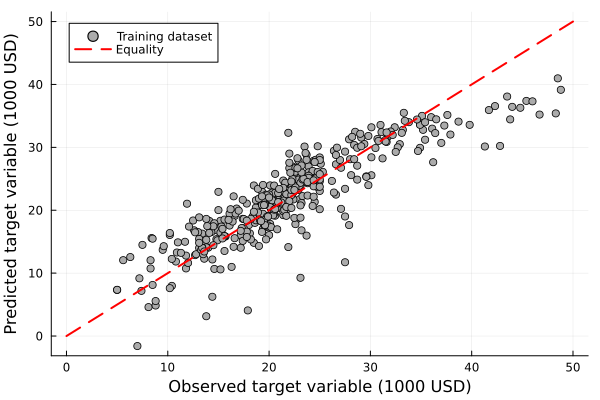

In [21]:
let

    Y = Array{Float64,2}(undef, number_of_training_examples_housing, 2);
    for i ∈ 1:number_of_training_examples_housing
        Y[i,1] = dot(X̂₁[i,:], β̂₁); # col 1: model simulated/predicted output
        Y[i,2] = y₁[i]; # col 2: observed output
    end

    XYLINE = range(0,stop=50,length=100) |> collect;
    scatter(Y[:,2], Y[:,1], c=:gray67, label="Training dataset")
    plot!(XYLINE,XYLINE,c=:red, lw=2, label="Equality", ls=:dash)
    ylabel!("Predicted target variable (1000 USD)", fontsize=18)
    xlabel!("Observed target variable (1000 USD)", fontsize=18)    
end

#### Estimate the Error model
Now that we have values for the $\hat{\beta}$ parameters, we can compute the error model. In particular, the variance of the error can be estimated by computing the residual vector:
$$
\begin{equation}
\Delta_{i} = y_{i} - \hat{y}_{i}\quad{i=1,2,\dots,n}
\end{equation}
$$
where $y_{i}$ denotes the `observed` house price and $\hat{y}_{i}$ represents the `predicted` house price using the model.
* __Impl__: We compute the residual values $\Delta_{i} = y_{i} - \hat{y}_{i}$ using a [`for`-loop](https://docs.julialang.org/en/v1/base/base/#for), fit a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) to the residuals using the [`fit_mle(...)` function (maximum likelihood estimation) exported by the `Distributions.jl` package](https://github.com/JuliaStats/Distributions.jl.git), and store both the fitted distribution and residual values. We save the error model in the `ϵ₁::Normal{Float64}` variable, and the residuals in the `Δ₁::Array{Float64,1}` variable.

In [23]:
ϵ₁, Δ₁ = let

    Y = Array{Float64,2}(undef, number_of_training_examples_housing, 2);
    for i ∈ 1:number_of_training_examples_housing
        Y[i,1] = dot(X̂₁[i,:], β̂₁); # col 1: model simulated/predicted output
        Y[i,2] = y₁[i]; # col 2: observed output
    end

    residual = Y[:,2] - Y[:,1]; # this is the Δ
    error_model = fit_mle(Normal, residual); # we don't know what this is yet, but we will!
    
    error_model, residual
end;

`Unhide` the code block below where we plotted the simulated and actual residual between the predicted and observed median home value:
* __Summary__: We expect the observed residual (blue line) and the [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) fit using [maximum likelihood estimation](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}) (red line) should be similar if the residuals are normally distributed. Indicators that our assumption of normally distributed residuals is flawed include multiple peaks or other characteristics like right or left skew in the observed residuals.
* Another interesting feature is a non-zero mean for the observed data; this suggests a systematic inability to capture the median price, i.e., the model is systematically off in either direction (in our case the model over predicts the price).

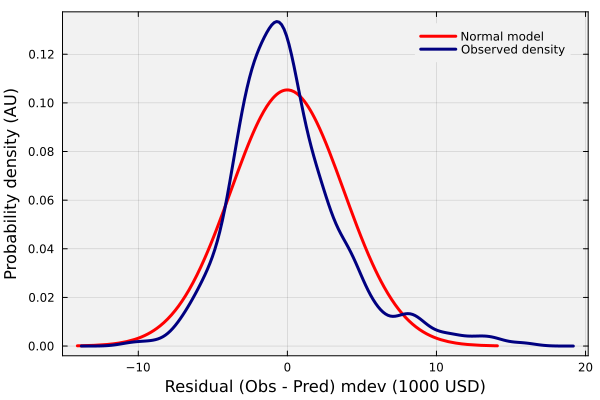

In [25]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    plot!(ϵ₁, label="Normal model", lw=3, c=:red)
    density!(Δ₁, label="Observed density", lw=3, c=:navy)
    xlabel!("Residual (Obs - Pred) mdev (1000 USD)", fontsize=18)
    ylabel!("Probability density (AU)", fontsize=18)
end

#### Goodness of fit `training` dataset
In addition to visually inspecting the predicted versus the observed values of the target variable, we can compute a variety of goodness of fit criteria to gauge how well the linear model describes the training data quantitatively. One very common measure is [the coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) or $R^{2}$.  The most general definition of the coefficient of determination is given by:
$$
\begin{equation}
R^{2} = 1 - \frac{\text{SS}_{res}}{\text{SS}_{tot}}
\end{equation}
$$
where $\text{SS}_{res}$ is the [residual sum of squares](https://en.wikipedia.org/wiki/Residual_sum_of_squares) given by $\text{SS}_{res} = \sum_{i=1}^{n}\Delta_{i}^{2}$
and $\text{SS}_{tot}$ is the [total sum of squares](https://en.wikipedia.org/wiki/Total_sum_of_squares) given by $\text{SS}_{tot} = \sum_{i=1}^{n}(y_{i} - \bar{y})^{2}$ where $\bar{y}$ denotes the mean value of the observations. The $R^{2}$ is related to the [fraction of unexplained variance (FUV)](https://en.wikipedia.org/wiki/Fraction_of_variance_unexplained)
$$
\text{FUV} = 1 - R^{2}
$$
Alternatively, we can compute [the squared correlation](https://en.wikipedia.org/wiki/Correlation) between the observed and simulated outputs, for example, using [the `cor(...)` function exported by the `Statistics.jl` package](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor)

In [27]:
let
    
    Y = Array{Float64,2}(undef, number_of_training_examples_housing, 2);
    for i ∈ 1:number_of_training_examples_housing
        Y[i,1] = dot(X̂₁[i,:],β̂₁);
        Y[i,2] = y₁[i];
    end

    # Method 1: Ratio of uncertainties
    ȳ = mean(Y[:,2]); # mean of the observed data
    SS_res = sum((Y[:,2] - Y[:,1]).^2) # sum of Δᵢ^2
    SS_tol = sum((Y[:,2] .- ȳ).^2);
    Rsq = 1 - SS_res/SS_tol;
    
    # Method 2: Correlation squared
    r = cor(Y[:,1], Y[:,2]) |> x-> x^2

    # package -
    df = DataFrame();
    row_df = (
        Rsq_1 = Rsq, # formula
        Rsq_2 = r, # 
        FUV = 1 - r
    )
    push!(df, row_df);
    pretty_table(df, tf=tf_simple)
end

=========== ========== ===========
     Rsq_1      Rsq_2        FUV 
   Float64    Float64    Float64 
=========== ========== ===========
  0.778641   0.778641   0.221359
=========== ========== ===========


#### Goodness of fit for the `test` dataset
Finally, let's compute the performance of the linear model on the `test` dataset using the parameters we estimated from the `training` dataset. We'll save the actual observed values for the median home prices in the `y₂::Array{Float64,1}` variable and the computed values in the `ŷ₂::Array{Float64,1}` variable.

In [29]:
y₂, ŷ₂ = let

    # setup: we are going to use the test data
    D = house_test; # What dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    
    # data
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias)
    y = D[:,end]; # output: this is the target data
    ŷ = X*β̂₁ # compute -

    y,ŷ
end;

`Unhide` the code block below to see how we plotted the `observed` versus the `predicted` median owner-occupied home value `mdev` for the _test_ dataset.
* __Summary__: If the model perfectly captured the training data, all the points would be on the equality line (red dashed line). However, some scattering around the equality line of the training data (gray points) indicates that the model captures the central trend, but other unmodeled factors may influence home prices. The _test_ data points (black points) follow a similar trend

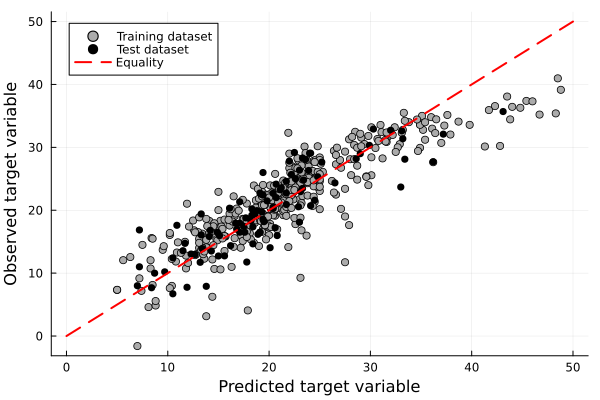

In [31]:
let
    XYLINE = range(0,stop=50,length=100) |> collect;
    scatter(y₁, ŷ₁, c=:gray67, label="Training dataset")
    scatter!(y₂, ŷ₂, c=:black, label="Test dataset")
    plot!(XYLINE,XYLINE,c=:red, lw=2, label="Equality", ls=:dash)
    xlabel!("Predicted target variable", fontsize=18)
    ylabel!("Observed target variable", fontsize=18)
end

The goodness of fit $R^{2}$ (and the fraction of unexplained variance) for the `test` dataset is similar to the `training` dataset (a little worse). This suggests the linear model can generalize to new (unseen) data!

In [33]:
let

    r₁ = cor(y₁, ŷ₁) |> x-> x^2; # case 1: compute R^2 for *training* data 
    r₂ = cor(y₂, ŷ₂) |> x-> x^2; # case 2: compute R^2 for *test* data 

    # package -
    df = DataFrame();
    row_df = (
        Rsq_training = r₁, #
        FUV_training = 1 - r₁,
        Rsq_test = r₂, #
        FUV_test = 1 - r₂
    )
    push!(df, row_df);
    pretty_table(df, tf=tf_simple)
end

=============== ============== ========== ===========
  Rsq_training   FUV_training   Rsq_test   FUV_test 
       Float64        Float64    Float64    Float64 
=============== ============== ========== ===========
      0.778641       0.221359   0.751812   0.248188
=============== ============== ========== ===========


## Linear models for classification tasks
Linear regression can be adapted for classification tasks by transforming the continuous output of the linear regression model directly to a class designation, e.g., $\sigma:\mathbb{R}\rightarrow\{-1,+1\}$ or into a probability using an output function $\sigma:\mathbb{R}\rightarrow\mathbb{R}$ and applying a threshold to categorize predictions into discrete classes. Let's take a look at two examples of these strategies:

* [The Perceptron (Rosenblatt, 1957)](https://en.wikipedia.org/wiki/Perceptron) is a simple yet powerful algorithm used in machine learning for binary classification tasks. It operates by _incrementally_ learning a linear decision boundary (linear regression model) that separates two classes based on input features by directly mapping the continuous output to a class such as $\sigma:\mathbb{R}\rightarrow\{-1,+1\}$, where the output function is $\sigma(\star) = \text{sign}(\star)$.
* [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression#) is a statistical method used in machine learning for binary classification tasks using the [logistics function](https://en.wikipedia.org/wiki/Logistic_function) as the transformation function. Applying the logistic function transforms the output of a linear regression model into a probability, enabling effective decision-making in various applications. We'll consider this approach next time.

### Perceptron
[The Perceptron (Rosenblatt, 1957)](https://en.wikipedia.org/wiki/Perceptron) takes the (scalar) output of a linear regression model $y_{i}\in\mathbb{R}$ and then transforms it using the $\sigma(\star) = \text{sign}(\star)$ function to a discrete set of values representing categories, e.g., $\sigma:\mathbb{R}\rightarrow\{-1,1\}$ in the binary classification case. 
* Suppose there exists a data set
$\mathcal{D} = \left\{(\mathbf{x}_{1},y_{1}),\dotsc,(\mathbf{x}_{n},y_{n})\right\}$ with $n$ _labeled_ examples, where each example has been labeled by an expert, i.e., a human to be in a category $\hat{y}_{i}\in\{-1,1\}$, given the $m$-dimensional feature vector $\mathbf{x}_{i}\in\mathbb{R}^{m}$. 
* [The Perceptron](https://en.wikipedia.org/wiki/Perceptron) _incrementally_ learns a linear decision boundary between _two_ classes of possible objects (binary classification) in $\mathcal{D}$ by repeatedly processing the data. During each pass, a regression parameter vector $\mathbf{\beta}$ is updated until it makes no more than a specified number of mistakes. 

[The Perceptron](https://en.wikipedia.org/wiki/Perceptron) computes the estimated label $\hat{y}_{i}$ for feature vector $\hat{\mathbf{x}}_{i}$ using the $\texttt{sign}:\mathbb{R}\to\{-1,1\}$ function:
$$
\begin{equation*}
    \hat{y}_{i} = \texttt{sign}\left(\hat{\mathbf{x}}_{i}^{\top}\cdot\beta\right)
\end{equation*}
$$
where $\beta=\left(w_{1},\dots,w_{n}, b\right)$ is a column vector of (unknown) classifier parameters, $w_{j}\in\mathbb{R}$ corresponding to the importance of feature $j$ and $b\in\mathbb{R}$ is a bias parameter, the features $\hat{\mathbf{x}}^{\top}_{i}=\left(x^{(i)}_{1},\dots,x^{(i)}_{m}, 1\right)$ are $p = m+1$-dimensional (row) vectors (features augmented with bias term), and $\texttt{sign}(z)$ is the function:
$$
\begin{equation*}
    \texttt{sign}(z) = 
    \begin{cases}
        1 & \text{if}~z\geq{0}\\
        -1 & \text{if}~z<0
    \end{cases}
\end{equation*}
$$
__Hypothesis__: If data set $\mathcal{D}$ is linearly separable, the Perceptron will _incrementally_ learn a separating hyperplane in a finite number of passes through the data set $\mathcal{D}$. However, if the data set $\mathcal{D}$ is not linearly separable, the Perceptron may not converge. Check out a [perceptron pseudo-code here!](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/docs/Notes.pdf)
* __Training__: Our Perceptron implementation [based on pseudo-code](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/docs/Notes.pdf) stores problem information in [a `MyPerceptronClassificationModel` instance, which holds the (initial) parameters and other data](src/Types.jl) required by the problem. We then _learn_ the model parameters [using the `learn(...)` method](src/Compute.jl), which takes the training features array `X,` the training labels vector `y`, and the problem instance and returns back an updated problem instance holding the updated parameters.

In [35]:
model = let

    # data -
    D = banknote_training; # What dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the target data (label)

    # model
    model = build(MyPerceptronClassificationModel, (
        parameters = ones(number_of_features), # initial value for the parameters: these will be updated
        mistakes = 0 # willing to like with m mistakes
    ));

    # train -
    model = learn(X,y,model, maxiter = 1000, verbose = true);

    # return -
    model;
end;

Stopped after number of iterations: 1000. We have number of errors: 4


Now that we have parameters estimated from the `training` data, we can use those parameters on the `test` dataset to see how well the model can differentiate between an actual banknote and a forgery on data it has never seen. 
* __Inference__: We run the classification operation on the (unseen) test data [using the `classify(...)` method](src/Compute.jl). This method takes a feature array `X` and the (trained) model instance. It returns the estimated labels. We store the actual (correct) label in the `y_banknote::Array{Int64,1}` vector, while the model predicted label is stored in the `ŷ_banknote::Array{Int64,1}` array.

In [37]:
ŷ_banknote,y_banknote = let

    D = banknote_test; # what dataset are going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # compute the estimated labels -
    ŷ = classify(X,model)

    # return -
    ŷ,y
end;

How many mistakes did the classifier make on the `test` dataset? Let's count the number of times $\hat{y}_{i}\neq{y}_{i}$, i.e., the inference predicts the wrong label.
* __Hmmm__. Does having the total error count tell us all the story?

In [39]:
number_of_prediction_mistakes = let

    number_of_test_examples = length(ŷ_banknote);
    error_counter = 0;

    for i ∈ 1:number_of_test_examples
        if (ŷ_banknote[i] != y_banknote[i])
            error_counter += 1;
        end
    end
    
    error_counter
end;

In [40]:
println("Perceptron mistake percentage: $((number_of_prediction_mistakes/length(ŷ_banknote))*100)%")

Perceptron mistake percentage: 1.3238289205702647%


## Today?
That's a wrap! What are four things we discussed today?